<a href="https://colab.research.google.com/github/shriyatijare21/A2_G4_Transaction_Fraud_Detection_System/blob/main/A2_G4_XGBoost_AimlMiniproj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# CELL 1: Setup & Install
!pip install kaggle xgboost gradio tqdm -q

import os
import time
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split

# Setup Kaggle API (upload kaggle.json first if needed)
os.environ['KAGGLE_CONFIG_DIR'] = '/content'
# If you uploaded kaggle.json, ensure permissions
try:
    !chmod 600 /content/kaggle.json
except Exception:
    pass

# Download dataset (uncomment if you want to download again)
!kaggle datasets download -d nelgiriyewithana/credit-card-fraud-detection-dataset-2023 -q
!unzip -o credit-card-fraud-detection-dataset-2023.zip

print("Install & imports complete.")


Dataset URL: https://www.kaggle.com/datasets/nelgiriyewithana/credit-card-fraud-detection-dataset-2023
License(s): other
Archive:  credit-card-fraud-detection-dataset-2023.zip
  inflating: creditcard_2023.csv     
Install & imports complete.


Dataset shape: (568630, 31)

Class distribution:
Class
0    284315
1    284315
Name: count, dtype: int64

Fraud percentage: 50.000000%

   id        V1        V2        V3        V4        V5        V6        V7  \
0   0 -0.260648 -0.469648  2.496266 -0.083724  0.129681  0.732898  0.519014   
1   1  0.985100 -0.356045  0.558056 -0.429654  0.277140  0.428605  0.406466   
2   2 -0.260272 -0.949385  1.728538 -0.457986  0.074062  1.419481  0.743511   
3   3 -0.152152 -0.508959  1.746840 -1.090178  0.249486  1.143312  0.518269   
4   4 -0.206820 -0.165280  1.527053 -0.448293  0.106125  0.530549  0.658849   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0 -0.130006  0.727159  ... -0.110552  0.217606 -0.134794  0.165959  0.126280   
1 -0.133118  0.347452  ... -0.194936 -0.605761  0.079469 -0.577395  0.190090   
2 -0.095576 -0.261297  ... -0.005020  0.702906  0.945045 -1.154666 -0.605564   
3 -0.065130 -0.205698  ... -0.146927 -0.038212 -0.214048 -1.893131  1

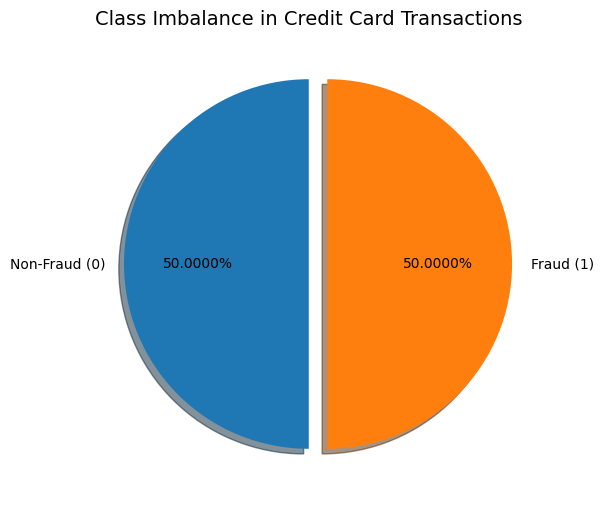


Data split complete. Train: (454904, 30), Test: (113726, 30)


In [ ]:
# CELL 2: Load, Explore & Split Data
DATA_PATH = "/content/creditcard_2023.csv"  # adjust if your filename differs

df = pd.read_csv(DATA_PATH)
print(f"Dataset shape: {df.shape}")
print("\nClass distribution:")
print(df['Class'].value_counts())
print(f"\nFraud percentage: {df['Class'].sum()/len(df)*100:.6f}%\n")
print(df.head())

# Visualize class imbalance
plt.figure(figsize=(6,6))
labels = ['Non-Fraud (0)', 'Fraud (1)']
sizes = df['Class'].value_counts().values
explode = (0, 0.1)
plt.pie(sizes, labels=labels, autopct='%1.4f%%', startangle=90, explode=explode, shadow=True)
plt.title("Class Imbalance in Credit Card Transactions", fontsize=14)
plt.show()

# Split features and target
X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"\nData split complete. Train: {X_train.shape}, Test: {X_test.shape}")


In [ ]:
# ============================================================================
# CELL 3: Train THREE Models (Logistic Regression, Random Forest, XGBoost)
# ============================================================================

from tqdm import tqdm
from xgboost import XGBClassifier

print("\nScaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n" + "="*70)
print(" TRAINING THREE MODELS")
print("="*70)

models = {}
train_times = {}

#  Logistic Regression ------------------------------------------------------
print("\n1 Training Logistic Regression...")
pbar_lr = tqdm(total=1, desc="Logistic Regression", ncols=80)

start_time = time.time()
logistic = LogisticRegression(
    max_iter=1000,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)
logistic.fit(X_train_scaled, y_train)

pbar_lr.update(1)
pbar_lr.close()
train_times['Logistic Regression'] = time.time() - start_time
models['Logistic Regression'] = logistic

#  Random Forest ------------------------------------------------------------
print("\n2 Training Random Forest...")
pbar_rf = tqdm(total=1, desc="Random Forest", ncols=80)

start_time = time.time()
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)
rf.fit(X_train_scaled, y_train)

pbar_rf.update(1)
pbar_rf.close()
train_times['Random Forest'] = time.time() - start_time
models['Random Forest'] = rf

#  XGBoost ------------------------------------------------------------------
print("\n3 Training XGBoost...")
pbar_xgb = tqdm(total=1, desc="XGBoost", ncols=80)

start_time = time.time()
xgb = XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss',
    n_jobs=-1
)
xgb.fit(X_train_scaled, y_train)

pbar_xgb.update(1)
pbar_xgb.close()
train_times['XGBoost'] = time.time() - start_time
models['XGBoost'] = xgb

# Save models
joblib.dump(logistic, 'logistic_model.joblib')
joblib.dump(rf, 'random_forest_model.joblib')
joblib.dump(xgb, 'xgboost_model.joblib')
joblib.dump(scaler, 'scaler.joblib')

print("\n All models trained and saved!")
for m, t in train_times.items():
    print(f"   {m}: {t:.2f} sec")



Scaling features...

 TRAINING THREE MODELS

1 Training Logistic Regression...


Logistic Regression: 100%|████████████████████████| 1/1 [00:04<00:00,  4.65s/it]



2 Training Random Forest...


Random Forest: 100%|█████████████████████████████| 1/1 [04:43<00:00, 283.71s/it]



3 Training XGBoost...


XGBoost: 100%|████████████████████████████████████| 1/1 [00:13<00:00, 13.77s/it]


 All models trained and saved!
   Logistic Regression: 4.65 sec
   Random Forest: 283.71 sec
   XGBoost: 13.78 sec


In [ ]:
# CELL 4: Evaluate & Compare Models (with tqdm)
comparison_results = []
model_items = list(models.items())

print("\nEvaluating models on test set...\n")
for name, model in tqdm(model_items, desc="Evaluating models", ncols=100):
    # Prediction and proba (robust)
    try:
        y_pred = model.predict(X_test_scaled)
    except Exception as e:
        # fallback to safe predict (rare)
        y_pred = np.zeros(len(X_test_scaled), dtype=int)

    try:
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
    except Exception:
        # fallback to decision_function scaled to [0,1] if available
        try:
            scores = model.decision_function(X_test_scaled)
            y_proba = (scores - scores.min()) / (scores.max() - scores.min() + 1e-9)
        except Exception:
            y_proba = np.zeros(len(X_test_scaled))

    accuracy = accuracy_score(y_test, y_pred)
    try:
        auc = roc_auc_score(y_test, y_proba)
    except Exception:
        auc = np.nan

    cr = classification_report(y_test, y_pred, digits=4)
    cm = confusion_matrix(y_test, y_pred)

    print("\n" + "="*60)
    print(f"Model: {name}")
    print("="*60)
    print(cr)
    print("Confusion matrix:")
    print(f"  TN: {cm[0,0]:,}  FP: {cm[0,1]:,}")
    print(f"  FN: {cm[1,0]:,}  TP: {cm[1,1]:,}")

    comparison_results.append({
        "Model": name,
        "Accuracy": accuracy,
        "AUC-ROC": auc,
        "True Positives": int(cm[1,1]),
        "False Negatives": int(cm[1,0]),
        "False Positives": int(cm[0,1])
    })

# Summary DataFrame
comparison_df = pd.DataFrame(comparison_results)
print("\n" + "="*60)
print("Overall comparison:")
print(comparison_df.to_string(index=False))

# Which model had best AUC?
if comparison_df['AUC-ROC'].notna().any():
    best_idx = comparison_df['AUC-ROC'].idxmax()
    print(f"\nBest model by AUC-ROC: {comparison_df.loc[best_idx, 'Model']} (AUC: {comparison_df.loc[best_idx, 'AUC-ROC']:.4f})")
else:
    print("\nAUC-ROC not available for comparison.")



Evaluating models on test set...



Evaluating models:  33%|███████████████▎                              | 1/3 [00:00<00:00,  9.90it/s]


Model: Logistic Regression
              precision    recall  f1-score   support

           0     0.9976    0.9990    0.9983     56863
           1     0.9990    0.9976    0.9983     56863

    accuracy                         0.9983    113726
   macro avg     0.9983    0.9983    0.9983    113726
weighted avg     0.9983    0.9983    0.9983    113726

Confusion matrix:
  TN: 56,805  FP: 58
  FN: 137  TP: 56,726


Evaluating models:  67%|██████████████████████████████▋               | 2/3 [00:01<00:01,  1.02s/it]


Model: Random Forest
              precision    recall  f1-score   support

           0     0.9997    0.9998    0.9998     56863
           1     0.9998    0.9997    0.9998     56863

    accuracy                         0.9998    113726
   macro avg     0.9998    0.9998    0.9998    113726
weighted avg     0.9998    0.9998    0.9998    113726

Confusion matrix:
  TN: 56,852  FP: 11
  FN: 16  TP: 56,847


Evaluating models: 100%|██████████████████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


Model: XGBoost
              precision    recall  f1-score   support

           0     0.9996    0.9999    0.9997     56863
           1     0.9999    0.9996    0.9997     56863

    accuracy                         0.9997    113726
   macro avg     0.9997    0.9997    0.9997    113726
weighted avg     0.9997    0.9997    0.9997    113726

Confusion matrix:
  TN: 56,855  FP: 8
  FN: 23  TP: 56,840

Overall comparison:
              Model  Accuracy  AUC-ROC  True Positives  False Negatives  False Positives
Logistic Regression  0.998285 0.999807           56726              137               58
      Random Forest  0.999763 0.999996           56847               16               11
            XGBoost  0.999727 0.999977           56840               23                8

Best model by AUC-ROC: Random Forest (AUC: 1.0000)


In [ ]:
# ============================================================================
# CELL 5: Gradio app + "About this transaction" donut WITHOUT SHAP
# (uses model coefficients & feature importances as contribution proxies)
# ============================================================================
!pip install xgboost -q

import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import gradio as gr

#print("Starting CELL 5 (SHAP-less contributor donut).")

# ---------------------------
# Paths & load items
# ---------------------------
DATA_PATH = "/content/creditcard_2023.csv"  # adjust if needed

load_items = [
    ("scaler", "scaler.joblib"),
    ("Logistic Regression", "logistic_model.joblib"),
    ("Random Forest", "random_forest_model.joblib"),
    ("XGBoost", "xgboost_model.joblib"),
]

loaded = {}
#print("Loading models and scaler...")
for name, fname in load_items:
    try:
        loaded[name] = joblib.load(fname)
        #print(f"  Loaded {fname}")
    except Exception as e:
        loaded[name] = None
        print(f"  Warning: could not load {fname} -> {e}")
print("Loading complete.\n")

# Map loaded objects to expected variables (if available)
scaler = loaded.get("scaler", None)
logistic_clf = loaded.get("Logistic Regression", None)
rf_clf = loaded.get("Random Forest", None)
xgb_clf = loaded.get("XGBoost", None)

# Load dataset for realistic sampling and for feature names
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"{DATA_PATH} not found. Please place the dataset at this path.")
df = pd.read_csv(DATA_PATH)
feature_columns = [c for c in df.columns if c != 'Class']

fraud_samples = df[df['Class'] == 1]
normal_samples = df[df['Class'] == 0]

# Build a small background stats on scaled features for reference (used for centering if needed)
bg = df[feature_columns].sample(n=min(200, len(df)), random_state=42).reset_index(drop=True)
if scaler is not None:
    bg_scaled = scaler.transform(bg.values)
else:
    bg_scaled = bg.values
# compute means (on scaled features). If scaler used, mean should be near 0.
feature_means_scaled = np.mean(bg_scaled, axis=0)

# model map
model_map = {
    "Logistic Regression": logistic_clf,
    "Random Forest": rf_clf,
    "XGBoost": xgb_clf
}

# safe sigmoid (for decision_function fallback)
def safe_sigmoid(x):
    x = np.asarray(x)
    if x.ndim == 0:
        xv = float(x)
    else:
        xv = float(np.ravel(x)[-1])
    if xv > 500: return 1.0
    if xv < -500: return 0.0
    return 1.0 / (1.0 + np.exp(-xv))

# ---------------------------
# Existing prediction function (unchanged behavior)
# ---------------------------
def generate_and_predict(user_amount):
    if np.random.random() < 0.3 and len(fraud_samples) > 0:
        sample = fraud_samples.sample(1).iloc[0].copy()
        base_pattern = "Fraud-like Pattern"
    else:
        sample = normal_samples.sample(1).iloc[0].copy()
        base_pattern = "Normal Pattern"

    user_amount = float(user_amount)
    sample['Amount'] = user_amount

    X_input = sample.drop('Class').values.reshape(1, -1)
    X_scaled = scaler.transform(X_input) if scaler is not None else X_input

    models_to_use = {
        "Logistic Regression": logistic_clf,
        "Random Forest": rf_clf,
        "XGBoost": xgb_clf
    }

    model_outputs = {}
    for name, model in models_to_use.items():
        if model is None:
            model_outputs[name] = {"prob": 0.0, "pred": 0, "ml_risk": "LOW"}
            continue

        try:
            prob = float(model.predict_proba(X_scaled)[0][1])
        except Exception:
            try:
                sc = model.decision_function(X_scaled)
                prob = safe_sigmoid(sc)
            except Exception:
                prob = 0.0

        pred = int(model.predict(X_scaled)[0])

        if prob > 0.7:
            ml_risk = "HIGH"
        elif prob > 0.3:
            ml_risk = "MEDIUM"
        else:
            ml_risk = "LOW"

        model_outputs[name] = {"prob": float(prob), "pred": pred, "ml_risk": ml_risk}

    # Rule overrides based on amount
    override_risk = None
    if user_amount <= 10:
        override_risk = "LOW"
    elif user_amount >= 50000:
        override_risk = "MEDIUM"
    elif user_amount >= 200000:
        override_risk = "HIGH"

    priority = {"LOW": 1, "MEDIUM": 2, "HIGH": 3}
    final_results = {}
    for name, data in model_outputs.items():
        ml_risk = data["ml_risk"]
        final_risk = ml_risk if override_risk is None else (override_risk if priority[override_risk] > priority[ml_risk] else ml_risk)
        final_results[name] = {"risk": final_risk, "prob": data["prob"], "pred": data["pred"]}

    # Build markdown
    result_md = f"""
## Transaction Summary
- *Amount Entered:* ₹{user_amount:,.2f}
- *Analyzed Pattern:* {base_pattern}
"""
    if override_risk:
        result_md += f"- *According To Amount Entered:* {override_risk} \n"

    result_md += "\n---\n## Model Predictions\n"
    for name, data in final_results.items():
        result_md += f"""
### {name}
- *Final Risk:* {data['risk']}
- *ML Probability of Fraud:* {data['prob']*100:.2f}%
- *Model Classified:* {"FRAUD" if data['pred']==1 else "LEGITIMATE"}
---
"""

    avg_prob = np.mean([m["prob"] for m in final_results.values()]) if final_results else 0.0
    if avg_prob > 0.7:
        consensus = "HIGH"
    elif avg_prob > 0.3:
        consensus = "MEDIUM"
    else:
        consensus = "LOW"

    if override_risk and priority[override_risk] > priority[consensus]:
        consensus = override_risk

    result_md += f"""
## Final Consensus
- *Consensus Risk:* {consensus}
- *Average Fraud Probability:* {avg_prob*100:.2f}%
"""
    return result_md

# ---------------------------
# Combined contributor donut generator (no SHAP)
# ---------------------------
def generate_contrib_donut(user_amount, top_n=8):
    """
    Computes per-feature contributions from each model using proxies:
     - LogisticRegression: coef * scaled_feature_value
     - Tree models: feature_importance * scaled_feature_value
    Aggregates across models and plots donut of top contributors.
    Returns matplotlib Figure.
    """
    try:
        # Sample transaction (same logic)
        if np.random.random() < 0.3 and len(fraud_samples) > 0:
            sample = fraud_samples.sample(1).iloc[0].copy()
            base_pattern = "Fraud-like Pattern"
        else:
            sample = normal_samples.sample(1).iloc[0].copy()
            base_pattern = "Normal Pattern"

        sample['Amount'] = float(user_amount)
        sample_features = sample.drop('Class').loc[feature_columns].values.reshape(1, -1)
        X_scaled = scaler.transform(sample_features) if scaler is not None else sample_features

        # accumulators
        combined_abs = {f: 0.0 for f in feature_columns}
        combined_signed = {f: 0.0 for f in feature_columns}
        probs = []

        # For each model compute contribution vector (length = n_features)
        for name, model in model_map.items():
            if model is None:
                continue

            # model probability for center (robust)
            try:
                p = float(model.predict_proba(X_scaled)[0][1])
            except Exception:
                try:
                    sc = model.decision_function(X_scaled)
                    p = safe_sigmoid(sc)
                except Exception:
                    p = 0.0
            probs.append(p)

            # Prepare per-feature contributions
            xs = X_scaled.ravel()  # scaled feature values for this sample (length n_features)

            contrib = np.zeros_like(xs, dtype=float)

            # Logistic: linear contributions
            try:
                if hasattr(model, "coef_") and np.size(model.coef_) > 0:
                    coef = np.ravel(model.coef_)
                    # if multiclass (coef shape > n_features) try to reduce by selecting first row or mean
                    if coef.size != xs.size:
                        # try to find a row matching features; fallback to first row
                        coef = np.ravel(model.coef_[0]) if model.coef_.ndim > 1 else coef.ravel()[:xs.size]
                        if coef.size != xs.size:
                            # pad or trim
                            coef = np.resize(coef, xs.size)
                    contrib = coef * xs
                else:
                    raise AttributeError
            except Exception:
                # Tree models: use feature_importances_ * signed feature deviation
                try:
                    if hasattr(model, "feature_importances_"):
                        imp = np.ravel(model.feature_importances_)
                        if imp.size != xs.size:
                            imp = np.resize(imp, xs.size)
                        # signed contribution: importance * feature_value (scaled)
                        contrib = imp * xs
                    else:
                        # fallback: use xs directly (weak signal)
                        contrib = xs
                except Exception:
                    contrib = xs

            # convert to python floats and accumulate
            for f_name, c_val in zip(feature_columns, contrib):
                combined_abs[f_name] += abs(float(c_val))
                combined_signed[f_name] += float(c_val)

        # If nothing accumulated (unlikely), fallback to using absolute scaled features
        if sum(combined_abs.values()) == 0:
            xs = X_scaled.ravel()
            for f_name, xval in zip(feature_columns, xs):
                combined_abs[f_name] = abs(float(xval))
                combined_signed[f_name] = float(xval)

        # Focus features: PCA V* + Amount + Time
        pca_feats = [f for f in feature_columns if f.upper().startswith('V')]
        optional_feats = [f for f in ['Amount', 'Time'] if f in feature_columns]
        focus_feats = pca_feats + optional_feats
        focus_feats = [f for f in focus_feats if f in feature_columns]
        if not focus_feats:
            focus_feats = feature_columns.copy()

        contribs = [(f, combined_abs.get(f, 0.0), combined_signed.get(f, 0.0)) for f in focus_feats]
        contribs_sorted = sorted(contribs, key=lambda x: x[1], reverse=True)

        top = contribs_sorted[:top_n]
        others = contribs_sorted[top_n:]
        others_sum = sum([c for (_, c, _) in others])
        labels = [f for (f, _, _) in top]
        abs_vals = [v for (_, v, _) in top]
        signed_vals = [s for (_, _, s) in top]

        if others:
            labels.append("Other")
            abs_vals.append(others_sum)
            signed_vals.append(sum([s for (_, _, s) in others]))

        # colors & styles
        colors = []
        alphas = []
        hatches = []
        for s in signed_vals:
            if s > 0:
                colors.append('#d62728'); alphas.append(0.95); hatches.append('')
            elif s < 0:
                colors.append('#1f77b4'); alphas.append(0.55); hatches.append('//')
            else:
                colors.append('#7f7f7f'); alphas.append(0.6); hatches.append('')

        # Create donut
        fig, ax = plt.subplots(figsize=(6,6))
        wedges, texts = ax.pie(abs_vals, labels=labels, startangle=140, wedgeprops=dict(width=0.35, edgecolor='w'))

        for w, c, a, h in zip(wedges, colors, alphas, hatches):
            w.set_facecolor(c); w.set_alpha(a)
            if h: w.set_hatch(h)

        avg_prob = np.mean(probs) if probs else 0.0
        #consensus = "HIGH" if avg_prob > 0.7 else ("MEDIUM" if avg_prob > 0.3 else "LOW")
        #ax.text(0, 0, f"{consensus}\n{avg_prob*100:.1f}%", ha='center', va='center', fontsize=14, weight='bold')

        ax.set_title("Combined contributor donut — top features (model-based proxy)", fontsize=14)
        plt.tight_layout()
        return fig

    except Exception as exc:
        # fallback figure with error text
        import traceback
        tb = traceback.format_exc()
        print("Error in generate_contrib_donut:", exc)
        print(tb)
        fig, ax = plt.subplots(figsize=(7,4))
        ax.axis('off')
        ax.text(0.5, 0.6, "Error generating contributor donut", ha='center', va='center', fontsize=14, color='red')
        ax.text(0.5, 0.35, str(exc), ha='center', va='center', fontsize=10)
        ax.text(0.5, 0.15, "See notebook output for traceback.", ha='center', va='center', fontsize=9)
        return fig

# ---------------------------
# Build Gradio UI (Analyze + About buttons)
# ---------------------------
with gr.Blocks(theme=gr.themes.Soft(), title="Fraud Detection (LogReg / RF / XGBoost)") as app:
    gr.Markdown("""
    # Transaction Fraud Detection System
    Enter a transaction amount and the system will show risk analyzed by three models.
    """)
    user_amount = gr.Number(label="Enter Transaction Amount (₹ or $)", value=100.0, minimum=0, step=10)
    analyze_btn = gr.Button(" Analyze Transaction", variant="primary", size="lg")
    output = gr.Markdown(label="Analysis Results")

    # New button for contributor donut
    about_btn = gr.Button(" About this transaction", variant="secondary", size="md")
    contrib_plot = gr.Plot(label="Contributor Donut Chart")

    # Hook up clicks
    analyze_btn.click(fn=generate_and_predict, inputs=user_amount, outputs=output)
    about_btn.click(fn=generate_contrib_donut, inputs=user_amount, outputs=contrib_plot)

    gr.Markdown("---\n### How it works\n1. You enter an amount\n2. The system samples a realistic transaction\n3. Models analyze it and a consensus is shown\n4. Click 'About this transaction' to see a combined-contributor donut showing top contributors\n")

print("\nLaunching Gradio app...")
app.launch(share=True, debug=False)


Loading complete.


Launching Gradio app...
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://29e7f6cba83ec4e2c4.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
